<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">Mécanique
            </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Forces centrales | Lois de Kepler
             </div>
        </div>
    </div>
</div>

In [1]:
# commande permettant d'insérer les figures matplotlib dans les notebooks
%matplotlib widget

# import des librairies 
import numpy as np
from scipy.integrate import odeint
from scipy import fft
import matplotlib.pyplot as plt

# Mise en œuvre du problème physique : lois de Kepler
## Problème physique à résoudre
L'application du principe fondamental de la dynamique permet d'établir la troisième loi de Kepler :
$$\dfrac{R^3}{T^2}=\dfrac{\mathcal{G}M}{4\pi^2}$$


&nbsp;
où $T$ est la période orbitale, $R$ le demi-grand axe de la trajectoire elliptique, $M$ la masse du centre attracteur et $\mathcal{G}$ la constante gravitationnelle universelle.

### Données planétaires
Les données planétaires sont disponibles sur Wikipédia et permettent dans un premier temps de tester cette loi sur les planètes qui composent le système solaire.

&nbsp;
On y ajoute les incertitudes-types associées à chaque grandeur.

In [2]:
# Données propres au système
R = np.array([57909050e3, 108209500e3, 149597887.5e3, 227944000e3, 778340000e3, 1426700000e3, 2870700000e3, 4498400000e3 ]) # Demi-grand axe (m) Mercure, Vénus, Terre, Mars, Jupiter, Saturne, Uranus, Neptune
T = np.array([87.969, 224.667, 365.256363,  686.885, 4332.01, 10754, 30698, 60216.8  ]) # Période (jour) Mercure, Vénus, Terre, Mars, Jupiter, Saturne, Uranus, Neptune
R_u = np.array(8*[1e3]) # incertitude-type uniforme (m) Mercure, Vénus, Terre, Mars, Jupiter, Saturne, Uranus, Neptune
T_u = np.array([0.0005, 0.0005, 0.0000005, 0.0005, 0.005, 0.5, 0.5, 0.05]) # incertitude-type uniforme (jour) Mercure, Vénus, Terre, Mars, Jupiter, Saturne, Uranus, Neptune
T_u = np.array(8*[0.0005]) # incertitude-type uniforme (jour) Mercure, Vénus, Terre, Mars, Jupiter, Saturne, Uranus, Neptune


G = 6.67430e-11
G_u = .000005e-11

## Tracé des points expérimentaux
On commence par tracer $\ln a$ en fonction de $\ln T$ pour vérifier le bon accord avec une loi linéaire :
$$\ln R = \dfrac{2}{3}\ln T + \dfrac{1}{2}\ln\left(\dfrac{\mathcal{G}M}{4\pi^2}\right)$$

&nbsp;
On s'assure ainsi que l'on obtient bien une droite dont on pourra ensuite calculer la valeur de pente et d'ordonnée à l'origine.

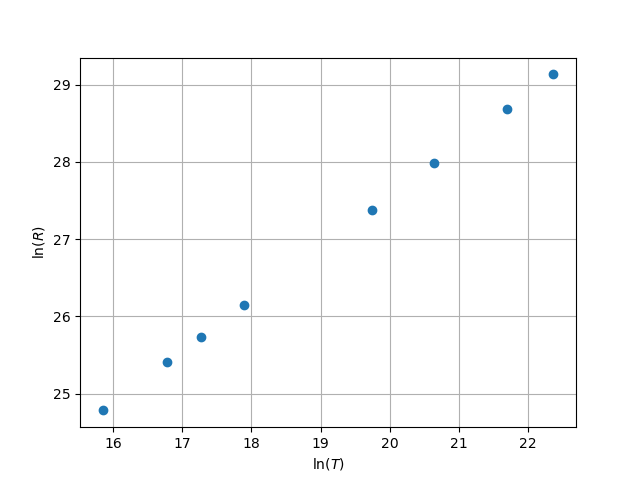

In [3]:
# Tracé du signal en fonction du temps
plt.figure()
plt.plot(np.log(T*24*3600),np.log(R), 'o')
plt.grid(True)
plt.xlabel(r'$\ln(T)$')
plt.ylabel(r'$\ln(R)$')
plt.show()

## Régression linéaire
La méthode `polyfit` (<a href="https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html">doc.</a>) de `numpy` permet alors de déterminer la pente et l'ordonnée à l'origine et de comparer ces valeurs à celles attendues.

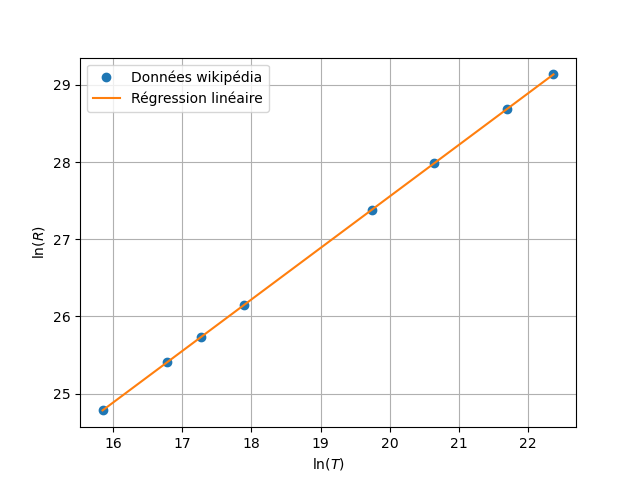

La pente attendue est :  6.6667e-01
La pente calculée est :  6.6669e-01


In [4]:
a,b=np.polyfit(np.log(T*24*3600),np.log(R),1)
time = np.linspace(np.min(T*24*3600), np.max(T*24*3600), 100000)

# Tracé du signal en fonction du temps
plt.figure()
plt.plot(np.log(T*24*3600),np.log(R), 'o' ,label="Données wikipédia")
plt.plot(np.log(time), a*np.log(time)+b, label="Régression linéaire")
plt.grid(True)
plt.legend()
plt.xlabel(r'$\ln(T)$')
plt.ylabel(r'$\ln(R)$')
plt.show()  

print("La pente attendue est : ",format(2/3,"#.4e"))
print("La pente calculée est : ",format(a,"#.4e"))

On peut également tracer les résidus ainsi que le z-score de cette régression linéaire qui donnent d'excellent résultats (presque trop bons...)

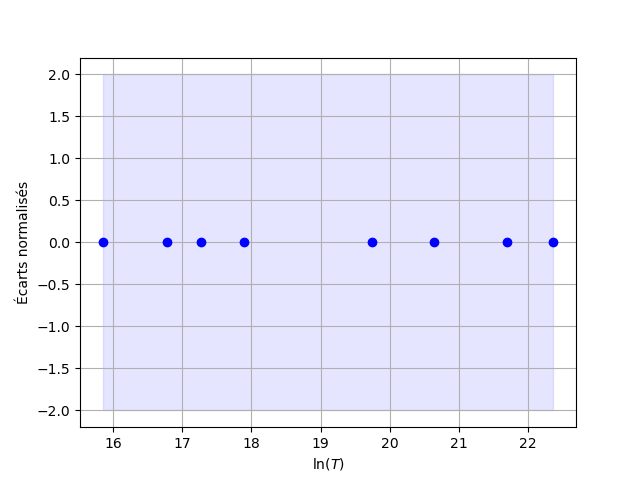

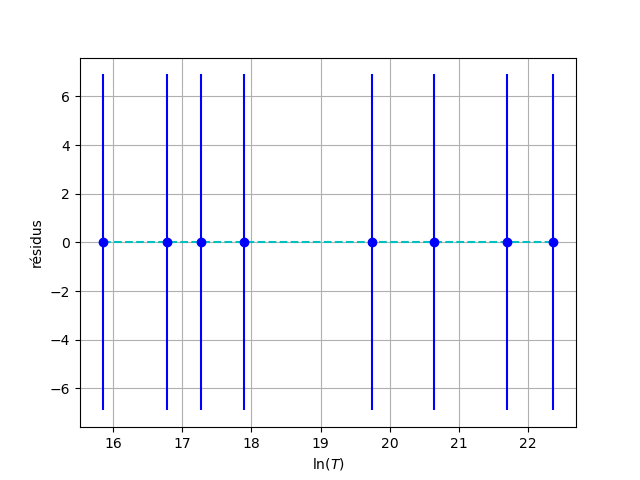

In [5]:
lnR_mod=a*np.log(T*24*3600)+b
res = lnR_mod-np.log(R)
lnR_u = np.log(R_u)
En = res/lnR_u

plt.figure()
plt.errorbar(np.log(T*24*3600), res, yerr = lnR_u, fmt = 'bo')    # résidus avec barres d'incertitude-type
plt.plot([np.min(np.log(T*24*3600)), np.max(np.log(T*24*3600))], [0, 0], 'c--')                    # pour mieux visualiser la droite correspondant à un résidu nul
plt.xlabel(r"$\ln(T)$")
plt.ylabel(r"résidus")
plt.grid()

plt.figure()
plt.plot(np.log(T*24*3600), En, 'bo')             # écarts normalisés
plt.fill_between([np.min(np.log(T*24*3600)), np.max(np.log(T*24*3600))], y1 = -2, y2 = 2, color = 'blue', alpha = .1)    # pour mieux visualiser le domaine des En acceptables
plt.xlabel(r"$\ln(T)$")
plt.ylabel(r"Écarts normalisés")
plt.grid()
plt.show()

## Masse du Soleil
On peut donc s'appuyer sur cette modélisation pour calculer la masse du centre attracteur, c'est-à-dire le Soleil, en utilisant une méthode de MonteCarlo pour tenir compte des incertitudes de mesure.

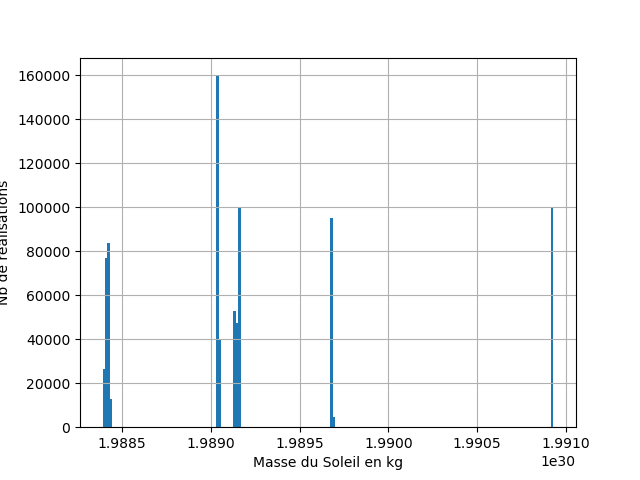

La masse du Soleil moyenne calculée est :  1.9892e+30 kg
L'incertitude type associée à cette mesure est :  7.506e+26 kg
La masse du Soleil notée dans Wikipédia est : 1.9891e+30 kg


In [6]:
M=[] # liste de stockages des diverses masses calculées pour les 8 planètes et les 100000 tirages aléatoires par planètes
for i in range(len(R)):
    for j in range(100000):
        # calcul d'une masse possible
        M.append(4*np.pi**2*(R[i]+R_u[i]*np.random.uniform(-1,1))**3/(((T[i]+T_u[i]*np.random.uniform(-1,1))*24*3600)**2*(G+G_u*np.random.uniform(-1,1))))

## Tracé de l'histogramme de distribution des valeurs calculées de M
plt.figure()
plt.hist(M,bins='rice', stacked=True)
plt.xlabel("Masse du Soleil en kg")
plt.ylabel("Nb de réalisations")
plt.grid(True)
plt.show()

## Calcul de la masse moyenne du Soleil et de l'écart-type associé
M_moy=np.mean(M)
M_u=np.std(M, ddof=1)

print("La masse du Soleil moyenne calculée est : ",format(M_moy,"#.4e"),"kg")
print("L'incertitude type associée à cette mesure est : ",format(M_u,"#.3e"),"kg")
print("La masse du Soleil notée dans Wikipédia est : 1.9891e+30 kg")

Le tracé du z-score des divers résultats est donné ci-dessous : 
    

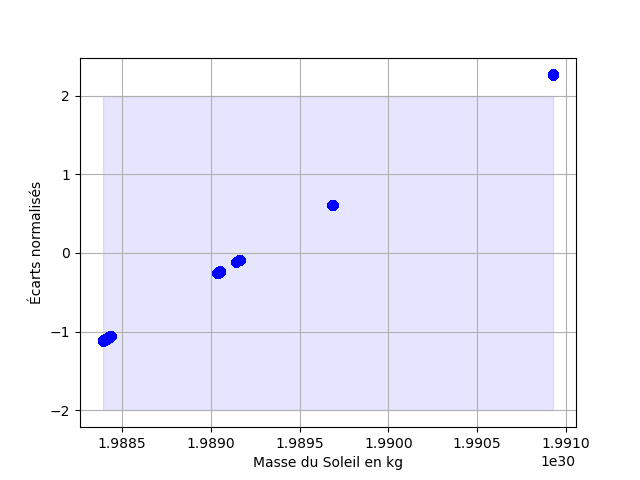

In [7]:
En = (np.array(M)-M_moy)/M_u

plt.figure()
plt.plot(np.array(M), En, 'bo')             # écarts normalisés
plt.fill_between([np.min(np.array(M)), np.max(np.array(M))], y1 = -2, y2 = 2, color = 'blue', alpha = .1)    # pour mieux visualiser le domaine des En acceptables
plt.xlabel(r"Masse du Soleil en kg")
plt.ylabel(r"Écarts normalisés")
plt.grid()
plt.show()

## Satellites de Saturne
On peut reprendre ce travail avec les 10 plus gros satellites de Saturne et comparer la masse calculée à celle de la littérature.


In [8]:
R=np.array([1221830e3, 527040e3, 3561300e3, 377400e3, 294660e3, 238020e3, 185520e3, 1481100e3, 151410e3, 377400e3])
R_u=np.array(10*[.5e3])
T=np.array([15.945421, 4.517500, 79.330183, 2.736915, 1.887802, 1.370218, 0.9424218, 21.276609, 0.6942, 2.7369])
T_u=np.array(10*[.000005])
G = 6.67430e-11
G_u = .000005e-11

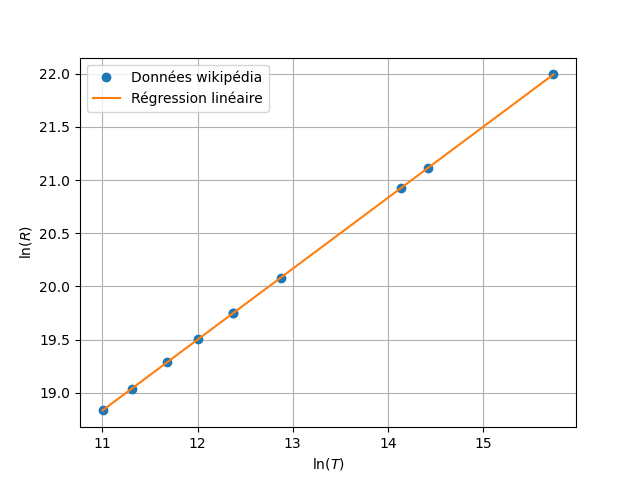

La pente attendue est :  6.6667e-01
La pente calculée est :  6.6650e-01


In [9]:
a,b=np.polyfit(np.log(T*24*3600),np.log(R),1)
time = np.linspace(np.min(T*24*3600), np.max(T*24*3600), 100000)

# Tracé du signal en fonction du temps
plt.figure()
plt.plot(np.log(T*24*3600),np.log(R), 'o' ,label="Données wikipédia")
plt.plot(np.log(time), a*np.log(time)+b, label="Régression linéaire")
plt.grid(True)
plt.legend()
plt.xlabel(r'$\ln(T)$')
plt.ylabel(r'$\ln(R)$')
plt.show()  

print("La pente attendue est : ",format(2/3,"#.4e"))
print("La pente calculée est : ",format(a,"#.4e"))

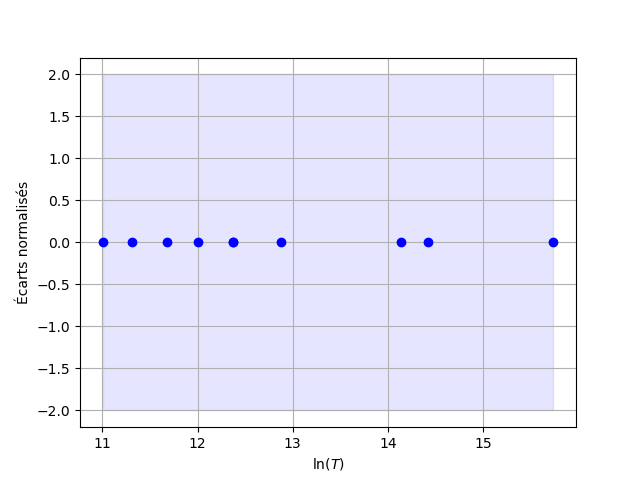

In [10]:
lnR_mod=a*np.log(T*24*3600)+b
res = lnR_mod-np.log(R)
lnR_u = np.log(R_u)
En = res/lnR_u

plt.figure()
plt.plot(np.log(T*24*3600), En, 'bo')             # écarts normalisés
plt.fill_between([np.min(np.log(T*24*3600)), np.max(np.log(T*24*3600))], y1 = -2, y2 = 2, color = 'blue', alpha = .1)    # pour mieux visualiser le domaine des En acceptables
plt.xlabel(r"$\ln(T)$")
plt.ylabel(r"Écarts normalisés")
plt.grid()
plt.show()

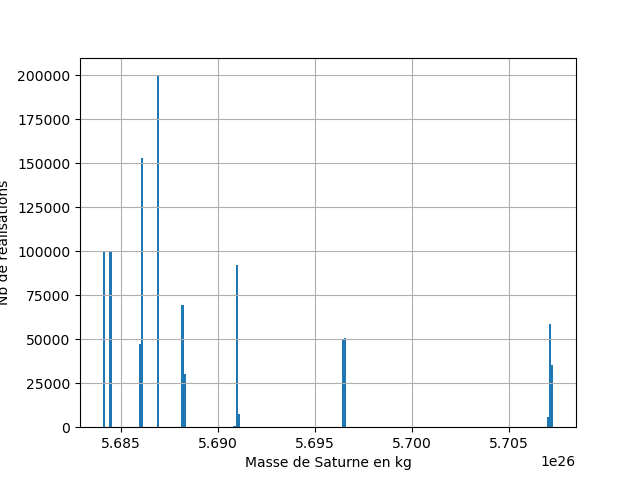

La masse de Saturne moyenne calculée est :  5.6897e+26 kg
L'incertitude type associée à cette mesure est :  6.758e+23 kg
La masse de Saturne notée dans Wikipédia est : 5.683e+26 kg


In [11]:
M=[] # liste de stockages des diverses masses calculées pour les 8 planètes et les 100000 tirages aléatoires par planètes
for i in range(len(R)):
    for j in range(100000):
        # calcul d'une masse possible
        M.append(4*np.pi**2*(R[i]+R_u[i]*np.random.uniform(-1,1))**3/(((T[i]+T_u[i]*np.random.uniform(-1,1))*24*3600)**2*(G+G_u*np.random.uniform(-1,1))))

## Tracé de l'histogramme de distribution des valeurs calculées de M
plt.figure()
plt.hist(M,bins='rice', stacked=True)
plt.xlabel("Masse de Saturne en kg")
plt.ylabel("Nb de réalisations")
plt.grid(True)
plt.show()

## Calcul de la masse moyenne de Saturne et de l'écart-type associé
M_moy=np.mean(M)
M_u=np.std(M, ddof=1)

print("La masse de Saturne moyenne calculée est : ",format(M_moy,"#.4e"),"kg")
print("L'incertitude type associée à cette mesure est : ",format(M_u,"#.3e"),"kg")
print("La masse de Saturne notée dans Wikipédia est : 5.683e+26 kg")

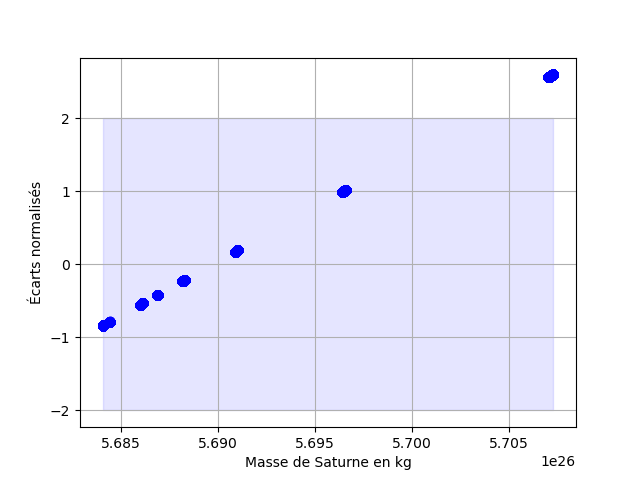

In [12]:
En = (np.array(M)-M_moy)/M_u

plt.figure()
plt.plot(np.array(M), En, 'bo')             # écarts normalisés
plt.fill_between([np.min(np.array(M)), np.max(np.array(M))], y1 = -2, y2 = 2, color = 'blue', alpha = .1)    # pour mieux visualiser le domaine des En acceptables
plt.xlabel(r"Masse de Saturne en kg")
plt.ylabel(r"Écarts normalisés")
plt.grid()
plt.show()